In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster
import leafmap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_3043/3540291395.py:4: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/opt/conda/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For

In [2]:
schema = 'projects_research'
table = 'arroyovivo_residuos_hex'
query = f"SELECT * FROM {schema}.{table}"
residuos = aup.gdf_from_query(query, geometry_col='geometry')

print(residuos.shape)
residuos.head(1)

(562, 51)


,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",13.0,24.0,0.0,0.0,36.0,44.0,0.0,...,207.0,259.0,89.0,137.0,1.0,1.0,1918.0,Plastico,2669.0,Plastico_quantity


In [3]:
residuos.columns

Index(['hex_id', 'res', 'geometry', 'aluminio', 'aluminio_quantity',
       'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 'cenizas',
       'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica',
       'electronica_quantity', 'escombros', 'escombros_quantity', 'goma',
       'goma_quantity', 'llantas', 'llantas_quantity', 'madera',
       'madera_quantity', 'metal', 'metal_quantity', 'organico',
       'organico_quantity', 'otros', 'otros_quantity', 'papel',
       'papel_quantity', 'pesca', 'pesca_quantity', 'plastico',
       'plastico_quantity', 'salud e higiene', 'salud e higiene_quantity',
       'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel',
       'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity',
       'total_points', 'most_common_point', 'total_quantity',
       'most_common_quantity'],
      dtype='object')

## Estandarización de los datos

In [4]:
coldatos = ['aluminio', 'aluminio_quantity',
       'baterias', 'baterias_quantity', 'carton', 'carton_quantity', 'cenizas',
       'cenizas_quantity', 'ceramica', 'ceramica_quantity', 'electronica',
       'electronica_quantity', 'escombros', 'escombros_quantity', 'goma',
       'goma_quantity', 'llantas', 'llantas_quantity', 'madera',
       'madera_quantity', 'metal', 'metal_quantity', 'organico',
       'organico_quantity', 'otros', 'otros_quantity', 'papel',
       'papel_quantity', 'pesca', 'pesca_quantity', 'plastico',
       'plastico_quantity', 'salud e higiene', 'salud e higiene_quantity',
       'tabaco', 'tabaco_quantity', 'tela', 'tela_quantity', 'unicel',
       'unicel_quantity', 'vidrio', 'vidrio_quantity', 'epi', 'epi_quantity']

# Create a StandardScaler
scaler = StandardScaler()

# Standardize the selected columns
residuos[coldatos] = scaler.fit_transform(residuos[coldatos])
residuos.head()

,hex_id,res,geometry,aluminio,aluminio_quantity,baterias,baterias_quantity,carton,carton_quantity,cenizas,...,unicel,unicel_quantity,vidrio,vidrio_quantity,epi,epi_quantity,total_points,most_common_point,total_quantity,most_common_quantity
0,8a48a20296a7fff,10,"POLYGON ((-100.30269 25.63956, -100.30201 25.6...",11.669761,9.057943,-0.103882,-0.084667,13.630210,12.220525,-0.127573,...,18.570515,14.079036,14.658037,12.070278,4.546442,2.893470,1918.0,Plastico,2669.0,Plastico_quantity
1,8a48a202978ffff,10,"POLYGON ((-100.30331 25.63839, -100.30263 25.6...",8.900164,12.544630,-0.103882,-0.084667,4.675946,3.926608,7.838651,...,4.922867,12.915738,4.036645,4.656423,-0.167765,-0.151718,1122.0,Plastico,2473.0,Plastico_quantity
2,8a48a202baaffff,10,"POLYGON ((-100.29357 25.64128, -100.29289 25.6...",-0.331826,-0.239891,-0.103882,-0.084667,1.561420,7.072577,-0.127573,...,0.009714,1.892108,0.327587,0.497432,-0.167765,-0.151718,847.0,Plastico,2994.0,Plastico_quantity
3,8a48a202ba1ffff,10,"POLYGON ((-100.29499 25.64119, -100.29431 25.6...",2.437771,0.922338,-0.103882,-0.084667,0.004156,-0.077352,-0.127573,...,1.192510,1.227367,8.588670,4.475598,-0.167765,-0.151718,810.0,Plastico,1672.0,Plastico_quantity
4,8a48a202ba0ffff,10,"POLYGON ((-100.29641 25.64109, -100.29573 25.6...",0.591373,0.147519,-0.103882,-0.084667,0.393472,0.208646,-0.127573,...,0.919557,1.116576,2.856490,3.209818,-0.167765,-0.151718,708.0,Plastico,1820.0,Plastico_quantity


### Verificamos estandarización

In [5]:
print("Media después de estandarización:")
print(residuos[coldatos].mean())

print("\nDesviación estándar después de estandarización:")
print(residuos[coldatos].std())

Media después de estandarización:
aluminio                   -5.057244e-17
aluminio_quantity          -2.528622e-17
baterias                    6.321555e-18
baterias_quantity          -1.264311e-17
carton                      0.000000e+00
carton_quantity             0.000000e+00
cenizas                    -6.321555e-18
cenizas_quantity            0.000000e+00
ceramica                    5.057244e-17
ceramica_quantity          -2.528622e-17
electronica                 0.000000e+00
electronica_quantity       -2.528622e-17
escombros                   2.528622e-17
escombros_quantity          0.000000e+00
goma                        2.528622e-17
goma_quantity               2.528622e-17
llantas                     0.000000e+00
llantas_quantity            0.000000e+00
madera                      2.528622e-17
madera_quantity             0.000000e+00
metal                       2.528622e-17
metal_quantity              0.000000e+00
organico                    2.528622e-17
organico_quantity      

# Dividir Dataset en Material y Quantity

## Material

In [6]:
col_material = ['hex_id', 'res','geometry', 'aluminio', 'baterias', 'carton','cenizas','ceramica','electronica','escombros',
                'goma','llantas','madera','metal','organico','otros','papel','pesca','plastico','salud e higiene',
                'tabaco','tela','unicel','vidrio','epi','total_points', 'most_common_point'] 
data_material = residuos[col_material].copy()
print(data_material.shape)

(562, 27)


### Res 11

In [7]:
data_material_11 = data_material[data_material['res'] == 11].copy()
print(data_material_11.shape)
data_material_11.head(2)

(420, 27)


,hex_id,res,geometry,aluminio,baterias,carton,cenizas,ceramica,electronica,escombros,...,pesca,plastico,salud e higiene,tabaco,tela,unicel,vidrio,epi,total_points,most_common_point
6,8b48a202baacfff,11,"POLYGON ((-100.29357 25.64128, -100.29339 25.6...",-0.331826,-0.103882,1.561420,-0.127573,-0.329080,-0.220429,4.817522,...,-0.134595,2.010942,0.588397,-0.455406,12.467905,0.009714,-0.009600,-0.167765,656.0,Plastico
9,8b48a20296a6fff,11,"POLYGON ((-100.30220 25.63975, -100.30201 25.6...",3.360970,-0.103882,2.340051,-0.127573,0.665238,2.257194,-0.034706,...,-0.134595,3.213488,2.034515,-0.455406,2.349179,4.376961,4.879613,-0.167765,517.0,Plastico


#### DBSCAN

**Parámetros óptimos**

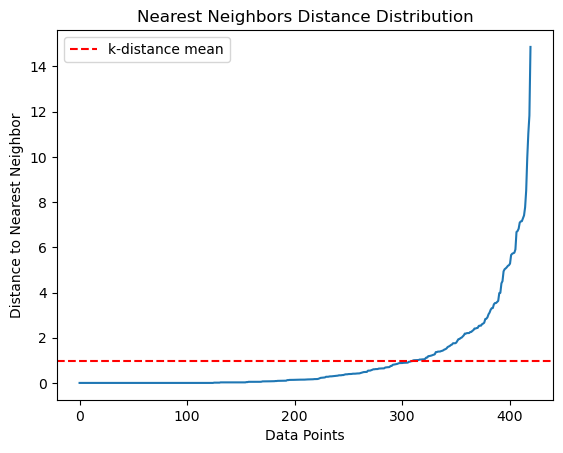

Valor óptimo eps: 0.9813776574664591


In [16]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

colclustering = ['aluminio', 'baterias', 'carton', 'cenizas', 'ceramica', 'electronica',
                           'escombros', 'goma', 'llantas', 'madera', 'metal', 'organico', 'otros',
                           'papel', 'pesca', 'plastico', 'salud e higiene', 'tabaco', 'tela', 'unicel',
                           'vidrio', 'epi']

# Assuming 'scaled_data' is your scaled data from the previous code snippet

# Calculate the Nearest Neighbors Distance Distribution
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(data_material_11[colclustering])
distances, _ = neighbors_fit.kneighbors(data_material_11[colclustering])

k_distance_mean = np.mean(distances[:, 1])

# Plot the sorted distances
sorted_distances = np.sort(distances[:, 1])
plt.plot(sorted_distances)
plt.axhline(y=k_distance_mean, color='r', linestyle='--', label='k-distance mean')
plt.xlabel('Data Points')
plt.ylabel('Distance to Nearest Neighbor')
plt.title('Nearest Neighbors Distance Distribution')
plt.legend()
plt.show()

print(f"Valor óptimo eps: {k_distance_mean}")

Varias páginas dicen que el min_samples tiene que ser 2 veces tu dimensión de los datos y se entiende como dimensión a las columnas de tu data, en este caso son 22 columnas en 'data_material_11[colclustering]' y por ende el valor óptimo es 44 min_samples y 0.981 eps.

**DBSCAN**

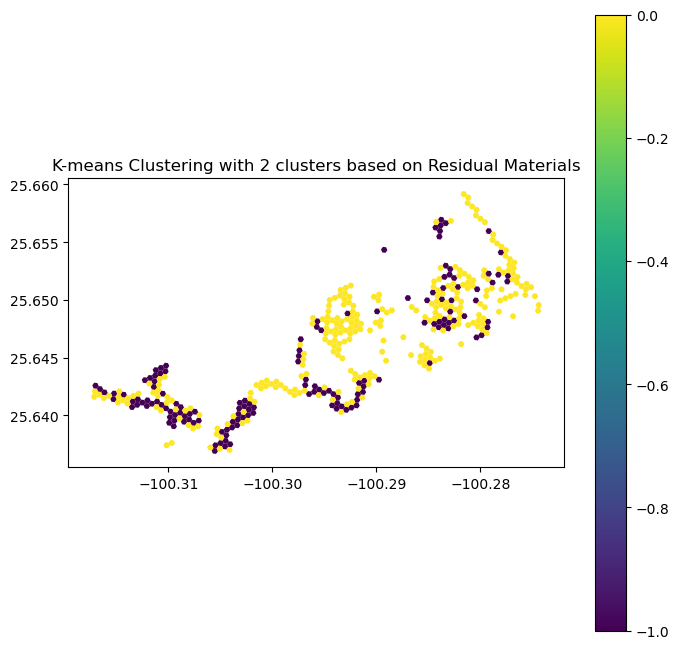

In [32]:
dbscan = DBSCAN(eps=k_distance_mean, min_samples=44)
data_material_11['cluster'] = dbscan.fit_predict(data_material_11[colclustering])
k = len(data_material_11['cluster'].unique())
fig, ax = plt.subplots(figsize=(8, 8))
data_material_11.plot(column='cluster', cmap='viridis', legend=True, ax=ax)
plt.title(f'K-means Clustering with {k} clusters based on Residual Materials')
plt.show()

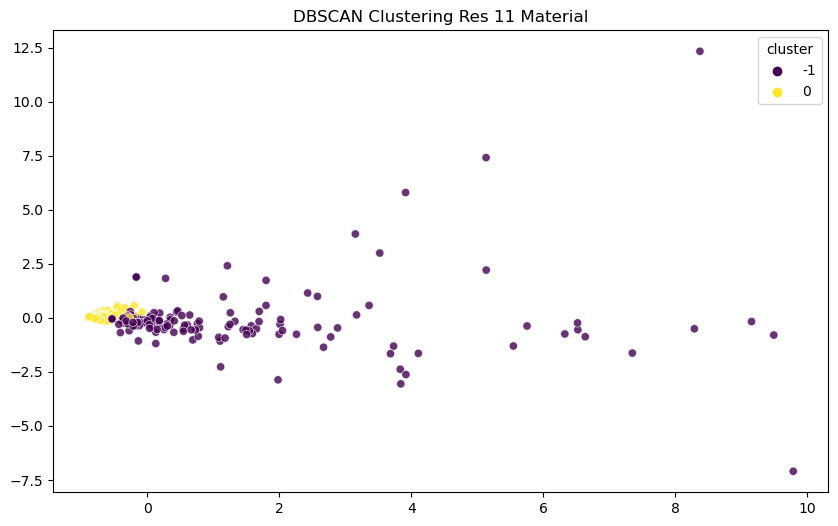

In [34]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_material_11[colclustering])

# Scatterplot of reduced data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data_material_11['cluster'], palette='viridis', legend='full', alpha=0.8)
plt.title('DBSCAN Clustering Res 11 Material')
plt.show()